In [1]:
import sys
import os
import pprint
import cPickle as pickle
import numpy as np
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib as mpl
from matplotlib import pyplot as plt
gleam_root = "/Users/phdenzel/gleam"
sys.path.append(gleam_root)
from gleam.utils.lensing import LensModel, DLDSDLS, DLSDS, DL, DS, find_einstein_radius
from gleam.utils.plotting import kappa_map_plot, arrival_time_surface_plot, kappa_profiles_plot
from gleam.utils.plotting import plot_scalebar, plot_labelbox
import gleam.utils.colors as gcl
gcl.GLEAMcmaps.register_all()
from mcmc_matching import load_lo, load_lm
from mcmc_eval import read_mcmctxt
from match_eval import read_matchlog


In [2]:
# Lens parameters
ids = ['SDSSJ0029-0055', 'SDSSJ0737+3216', 'SDSSJ0753+3416', 'SDSSJ0956+5100',
       'SDSSJ1051+4439', 'SDSSJ1430+6104', 'SDSSJ1627-0053']
idx = 0
lens = ids[idx]
pixrad = 11
zl_mdl = 0.23
zs_mdl = 0.8
mdir = 'match_plots/{lens}/'.format(lens=lens)
sdir = os.path.join(mdir, 'sorted')

bestof = 21
print(lens)


SDSSJ0029-0055


In [3]:
# load list of best models (modelled w/o & w/ PSF)
mcmcmdl_range, chi2, mcmcangles = read_mcmctxt('mcmc/mcmceval_{}.txt'.format(lens))
chi2 = np.log(-2*chi2)
matchlog = '{}{}_matching.log'.format(mdir, lens)
matchmdl_range, chi2_psf, matchangles = read_matchlog(matchlog)
sortidcs = np.argsort(chi2_psf)
matchmdl_range = matchmdl_range[sortidcs]
chi2_psf = chi2_psf[sortidcs]
matchangles = matchangles[sortidcs]

# mdlidcs = np.concatenate((mcmcmdl_range[:bestof], matchmdl_range[:bestof]))

mdlidcs = mcmcmdl_range
angles = mcmcangles

print mdlidcs[:bestof]
print angles[:bestof]


[599 229 551 464 282 585 384 584 675  67 562 586 367 424 604 281 546 490
 552 489 475]
[[  0.95]
 [  0.94]
 [  0.94]
 [  0.92]
 [359.17]
 [  0.82]
 [  0.97]
 [  0.96]
 [359.12]
 [359.18]
 [  0.96]
 [359.15]
 [359.12]
 [  0.86]
 [  1.05]
 [  0.94]
 [  0.94]
 [  0.92]
 [359.13]
 [  1.02]
 [  0.89]]


In [4]:
lm = load_lm(lens, update_pixrad=pixrad, verbose=False)
# lm.rescale(zl_new=zl_mdl, zs_new=zs_mdl)
print(lm.__v__)


filename            	SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl
filepath            	models/SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl
N                   	697
pixrad              	80
maprad              	4.0
pixel_size          	0.0496894409938
kappa               	None
minima              	[]
saddle_points       	[]
maxima              	[]
zl                  	0.227
zs                  	0.9313


In [5]:
lm = lm.subset(mdlidcs[:bestof])
print(lm.__v__)


filename            	SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl
filepath            	models/SDSSJ0029-0055_kappa_re0.97_zl0.23zs0.93.pkl
N                   	21
pixrad              	80
maprad              	4.0
pixel_size          	0.0496894409938
kappa               	None
minima              	[]
saddle_points       	[]
maxima              	[]
zl                  	0.227
zs                  	0.9313


In [6]:
dl = DL(lm.zl, lm.zs)
dlsds = DLSDS(lm.zl, lm.zs)
dldsdls = DLDSDLS(lm.zl, lm.zs)
lfactor = (1.+lm.zl)
sfactor = (1.+lm.zs)
print("DL: {:6.4f}, DLSDS: {:6.4f}, DLDSDLS: {:6.4f}".format(dl, dlsds, dldsdls))
print("DL factor: {}".format(lfactor))
print("DS factor: {}".format(sfactor))
print("Kappa factor: {}".format( np.pi * lfactor ))
# print("DLSDS factor: {}".format( (1.+lm.zs)/(1.+lm.zl) ))
# lsfactor = (1.+lm.zs)/(1.+lm.zl)


DL: 0.1758, DLSDS: 0.7085, DLDSDLS: 0.2481
DL factor: 1.227
DS factor: 1.9313
Kappa factor: 3.85473418595


In [7]:
# rescale kappa_inf maps
lm.data = np.pi * lm.data[:] * lfactor
lm.models = [d for d in lm.data]


In [8]:
# %%script false
# rotate models
for alpha, imdl in zip(angles, mdlidcs):
    print(alpha, imdl)
    dta = ndimage.rotate(lm.data[imdl], alpha, reshape=False)
    lm.data[imdl] = dta.copy()
    lm.models[imdl] = dta.copy()


(array([0.95]), 599)


IndexError: index 599 is out of bounds for axis 0 with size 21

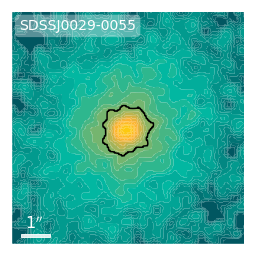

In [9]:
kappa_map_plot(lm, mdl_index=0, extent=lm.extent,
               log=True, oversample=True,
               contours=True, levels=17, delta=0.1,
               scalebar=True, label=lens)
plt.show()


In [10]:
dims = (2*lm.pixrad+1) # * lm.env.objects[0].basis.subdivision
darr = lm.data.copy()
darr = darr.reshape((darr.shape[0], dims**2))
# darr = darr - ea_flat

print darr.shape, np.mean(darr)


(21, 25921) 0.29538054416421594


In [11]:
# Standardize data
scaler = StandardScaler(with_std=False)  # calculate (data - mu) / sigma=1
scaler.fit(darr)
std_arr = scaler.transform(darr)


In [12]:
Npc = bestof-1
pca = PCA(n_components=Npc)
pca.fit(std_arr)
print std_arr.shape


(21, 25921)


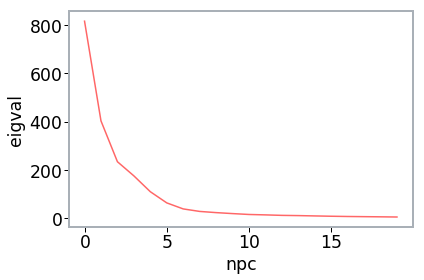

In [13]:
plt.plot(pca.explained_variance_, color=gcl.red)
plt.xlabel('npc')
plt.ylabel('eigval')
plt.tight_layout()
plt.show()


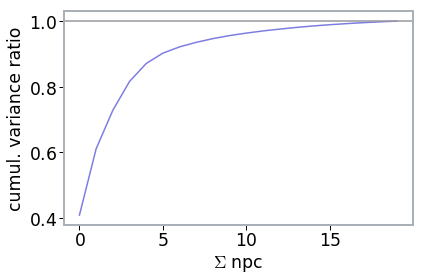

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), color=gcl.purpleblue)
plt.axhline(1, color=gcl.grey)
plt.xlabel(r'$\Sigma$ npc')
plt.ylabel('cumul. variance ratio')
plt.tight_layout()
plt.show()


In [15]:
pcacs = pca.components_
pcacs = pcacs.reshape((pcacs.shape[0], dims, dims))
print pcacs.shape


(20, 161, 161)


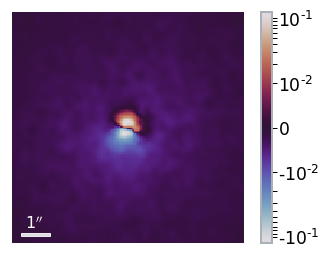

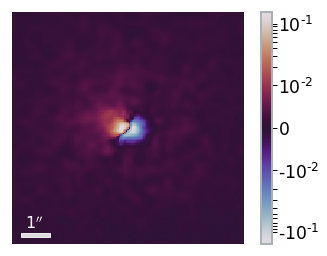

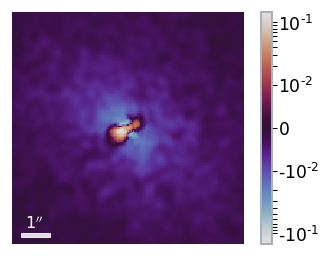

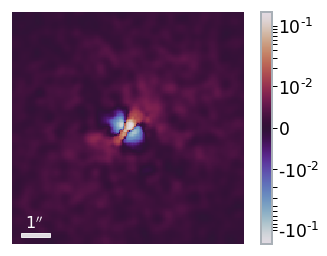

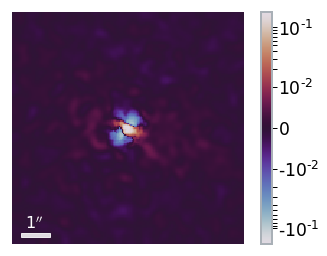

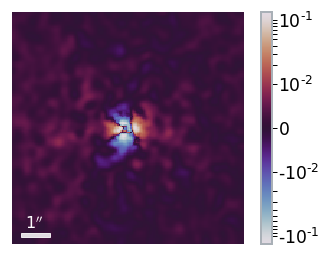

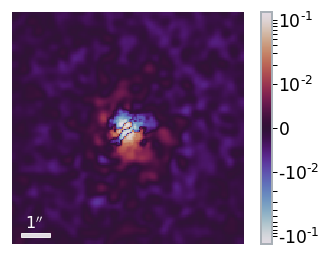

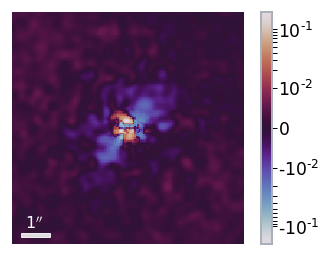

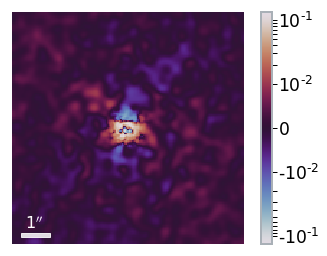

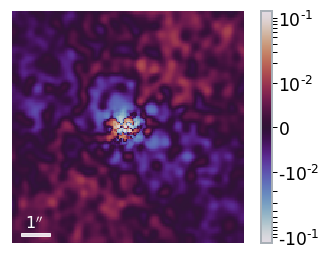

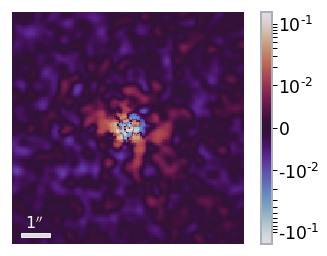

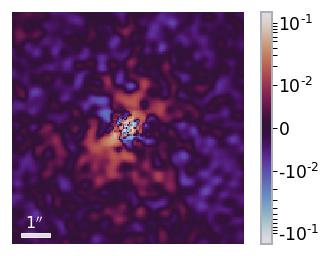

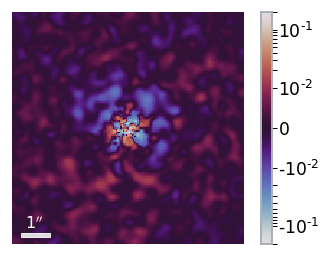

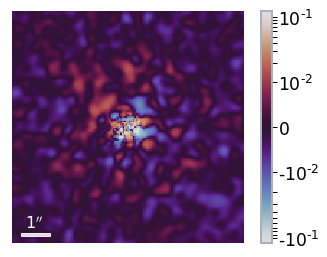

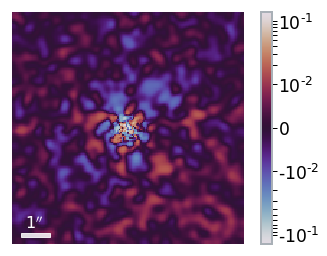

In [18]:
for i in range(min(Npc, 15)):
    val = np.max(np.abs(pcacs[i]))
    plt.imshow(pcacs[i], extent=lm.extent, vmin=-val, vmax=val, cmap='twilight',
               norm=mpl.colors.SymLogNorm(1e-2))
    plot_scalebar(lm.maprad, length=max(int(lm.maprad/4), 1))
    plt.axis('off')
    plt.gcf().axes[0].get_xaxis().set_visible(False)
    plt.gcf().axes[0].get_yaxis().set_visible(False)
    plt.colorbar()
    plt.show()
    plt.close()


In [17]:
%%script false
# calculate dot products between data vectors and the eigenvectors
npca = 0
warr = std_arr.reshape((bestof, dims, dims)) * pcacs[npca, :]
dotprods = np.sum(warr, axis=(1, 2))
order_dotprods = dotprods.argsort()[::-1]
print dotprods.shape
print dotprods.max(), dotprods.min()
print dotprods[order_dotprods[160]], dotprods[order_dotprods[840]]
print order_dotprods[0:10], order_dotprods[-10:]

projections = np.array([d*pcacs[npca, :] for d in dotprods])
print projections.shape
